# **Imports**

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
import glob

import cupy as cp

import tensorflow as tf
import tensorflow.keras as keras

from tqdm import tqdm

from temnn.knet import MSDnet, Unet
# from temnn.analysis.analysis import evaluate_examples
from temnn.analysis.analysis import F1_percentage
# from temnn.analysis.analysis import find_examples, plot_example
from temnn.analysis.SimulatedAnalysis import Simulated_Data

from skimage.filters import gaussian
from scipy.ndimage.filters import gaussian_filter

from temnn.knet.ReflectionPadding2D import ReflectionPadding2D

# **Input**

Below set reproducibility to true if you have trained multiple networks on t he same dataset and would like to evaluate the reproducibility of the networks training.

Set comparison to True if you have two networks you want to compare, for example an MSDnet and Unet trained on the same dataset.

In [2]:
reproducibility = False
comparison = True

## *Dataset folder*

Now specify which dataset you would like to use for validation, and then which network.

In [3]:
# dataset = 'Au_fcc_mixed_mask_lorentzMTFextracorr_lowdose'
dataset = 'continuous_dose_series'
fn = '../simulation_data/' + dataset

## *Neural Networks & Dataset Parameters*

In [4]:
d1_nn = '../trained_networks/MSDnet_Au_fcc_CeO2_MTF4_22112022'
if comparison:
    d2_nn = '../trained_networks/MSDnet_Au_fcc_CeO2_MTF3_22112022'

In [5]:
image_parameters_file = fn + '/parameters.json'
image_label_files = sorted(glob.glob(fn + '/images_labels/*.npz'))
tem_parameters_files = sorted(glob.glob(fn + '/tem_params/*'))

In [6]:
# Find the latest CNN model
d1_nn = os.path.join(d1_nn,'model-0')
mod1 = keras.models.load_model(d1_nn)
print("Using CNN model in", d1_nn)

if comparison:
    d2_nn = os.path.join(d2_nn,'model-0')
    mod2 = keras.models.load_model(d2_nn)
    print("Using CNN model in", d2_nn)

Using CNN model in ../trained_networks/MSDnet_Au_fcc_CeO2_MTF4_22112022/model-0
Using CNN model in ../trained_networks/MSDnet_Au_fcc_CeO2_MTF3_22112022/model-0


# **Metrics**

## *F1 Score*

In [7]:
f1_1 = []
dose = []
if comparison:
    f1_2 = []
for i in tqdm(np.arange(len(image_label_files))):
    simulated_data = Simulated_Data(image_label_files[i],
                                    image_parameters_file,
                                    tem_parameters_files[i])
    simulated_data.load()
    dose.append(simulated_data.dose)
    image = simulated_data.cp_local_standardise()
    inference = simulated_data.infer(mod1)
    f1_1.append(simulated_data.get_F1_score(threshold=0.9, neglect_background=False))
    if comparison:
        inference = simulated_data.infer(mod2)
        f1_2.append(simulated_data.get_F1_score(threshold=0.9, neglect_background=False))

100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]


### *Percentage of examples above specified F1 value*

In [8]:
p1 = F1_percentage(np.asarray(f1_1))
print("{:.1f}% of examples above F1=0.8".format(p1))
if comparison:
    p2 = F1_percentage(np.asarray(f1_2))
    print("{:.1f}% of examples above F1=0.8".format(p2))

77.7% of examples above F1=0.8
71.2% of examples above F1=0.8


### *F1 histogram between two different networks*

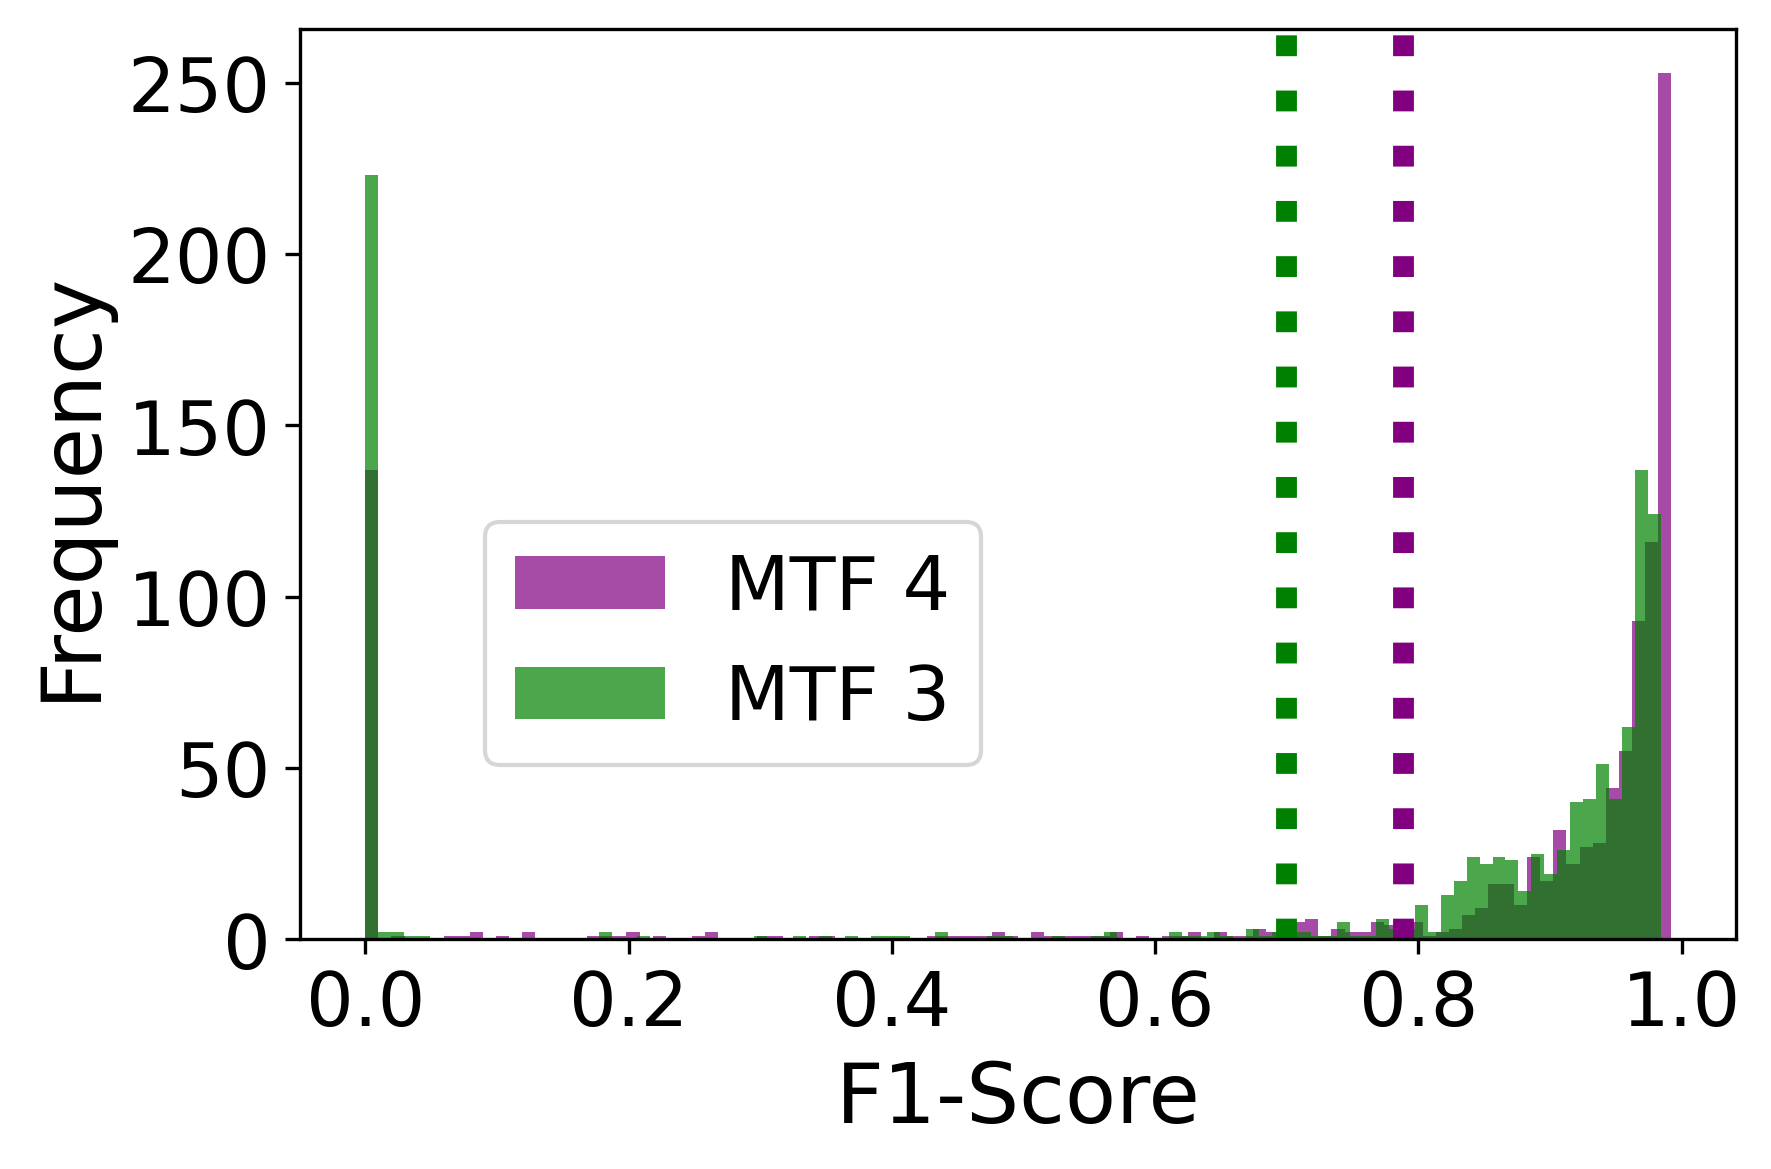

In [9]:
plt.hist(f1_1, bins=100, histtype='stepfilled', linewidth=3, label='MTF 4', alpha=0.7, color='purple')
plt.axvline(statistics.mean(f1_1),color='purple',
            linestyle='dotted', linewidth=5)
            #label=f"{p1:.1f}% of examples above F1=0.8")

if comparison:
    plt.hist(f1_2, bins=100, histtype='stepfilled', linewidth=3, label='MTF 3', alpha=0.7, color='green')
    plt.axvline(statistics.mean(f1_2),color='green',
                linestyle='dotted', linewidth=5)#,
                #label=f"{p2:.1f}% of examples above F1=0.8")

# axs.set_xlim([0.0,1.0])
plt.xlabel('F1-Score', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

plt.legend(loc='best', bbox_to_anchor=(0., 0., 0.5, 0.5), fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('contdoseseries_mtf4vmtf3_hist_MSDnet.png')
plt.show()

<ipython-input-10-fdeec31ce9dc>:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


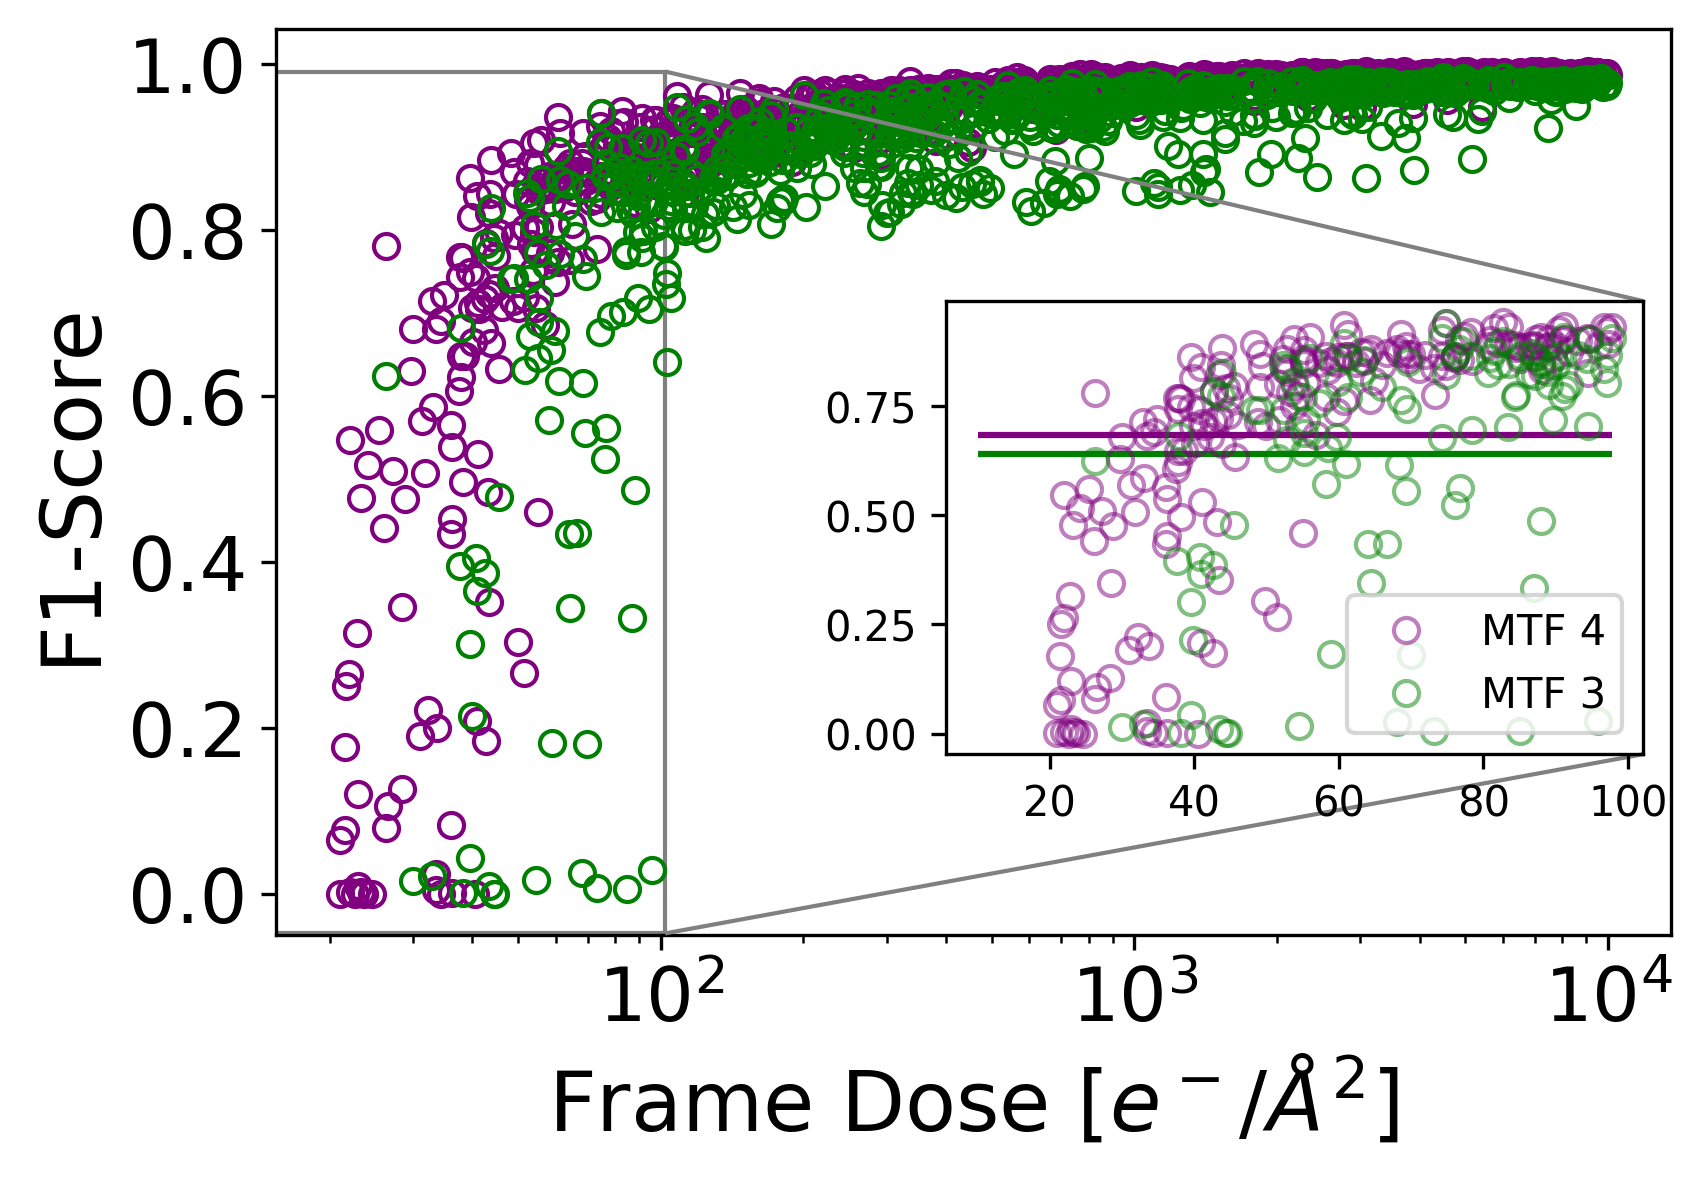

In [10]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

fig, ax1 = plt.subplots()
f1_1_clean = np.asarray(f1_1.copy())
f1_2_clean = np.asarray(f1_2.copy())
f1_1_clean[f1_1_clean == 0] = np.nan
f1_2_clean[f1_2_clean == 0] = np.nan

ax1.plot(dose, f1_1_clean, 'o', label='MTF 4', alpha=1, linewidth=20, color='purple', markerfacecolor='none')
ax1.plot(dose, f1_2_clean, 'o', label='MTF 3', alpha=1, linewidth=20, color='green', markerfacecolor='none')
ax1.set_xlabel('Frame Dose [$e^-$/$Å^2$]',fontsize=20)
ax1.set_ylabel('F1-Score',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)

###################
dose = np.asarray(dose)
p = dose.argsort()
dose_sort = dose[p]
f1_1_clean_sort = f1_1_clean[p]
f1_2_clean_sort = f1_2_clean[p]

lim = np.max(np.where(dose_sort<100))

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.48,0.2,0.5,0.5])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=1, loc2=4, fc="none", ec='0.5')

ax2.plot(dose_sort[:lim], f1_1_clean_sort[:lim], 'o', label='MTF 4', alpha=0.5, linewidth=20, color='purple', markerfacecolor='none')
ax2.plot(dose_sort[:lim], f1_2_clean_sort[:lim], 'o', label='MTF 3', alpha=0.5, linewidth=20, color='green', markerfacecolor='none')
ax2.hlines(np.nanmean(f1_1_clean_sort[:lim]), np.min(dose_sort[:lim]), np.max(dose_sort[:lim]), color='purple')
ax2.hlines(np.nanmean(f1_2_clean_sort[:lim]), np.min(dose_sort[:lim]), np.max(dose_sort[:lim]), color='green')
# ax2.set_xscale('log')

ax2.legend(loc='lower right', fontsize=10)
###################

# plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('contdoseseries_mtf4vmtf3_MSDnet.png', bbox_inches='tight')
plt.show()

In [11]:
import glob 

image_parameters_file = fn + '/parameters.json'
image_label_files = sorted(glob.glob(fn + '/images_labels/*.npz'))
tem_parameters_files = sorted(glob.glob(fn + '/tem_params/*'))

In [12]:
from temnn.analysis.SimulatedAnalysis import Simulated_Data

def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2]

print(f'mean: {statistics.mean(f1_1)}, median: {statistics.median(f1_1)}')
idx = argmedian(f1_1)
print(f'F1 score: {f1_1[idx]}')
cmap= 'gray'

simulated_data = Simulated_Data(image_label_files[idx], image_parameters_file, tem_parameters_files[idx])
simulated_data.load()
image = simulated_data.cp_local_standardise().copy()
inference = simulated_data.infer(mod2).copy()

simulated_data.plot(cmap=cmap)
plt.show()

mean: 0.7879887397216038, median: 0.9553277849430057
F1 score: 0.9553313883531952


<Figure size 1800x1200 with 0 Axes>

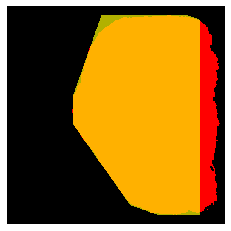

In [13]:
from matplotlib import colors
import copy

cmap1 = colors.ListedColormap(['red'])
cmap2 = colors.ListedColormap(['yellow'])

background = np.where(inference[0,:,:,0].T > 0.5, 1, 0)
overlay = simulated_data.label[:,:,0].T

bg_mask = np.ma.masked_where(background == 0, background)
ovr_mask = np.ma.masked_where(overlay == 0, overlay)

plt.axis('off')

cmap1.set_bad('black')
plt.imshow(bg_mask, origin='lower', cmap=cmap1)
plt.imshow(ovr_mask, origin='lower', cmap=cmap2, alpha=0.7)
plt.show()